# The Annotated Transformer Tutorial
This is a reimplementation of the famous [Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html) that I did to better understand the transformer.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pdb

import numpy as np
np.set_printoptions(precision=4)

import math, copy, time
from torch.autograd import Variable

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context(context="talk")
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F

## Model Architecture

In [5]:
def clones(module, N):
  """
  Produce N identitcal layers.
  """
  return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [3]:
class EncoderDecoder(nn.Module):
  """
  A standard Encoder-Decoder architecture. Base for this and
  many other models. 
  """
  def __ini__(self, encoder, decoder, src_embed, tgt_embed, generator):
    super(EncoderDecoder, self).__ini__()
    self.encoder = encoder 
    self.decoder = decoder 
    self.src_embed = src_embed 
    self.tgt_embed = tgt_embed
    self.generator = generator
    
  def forward(self, src, tgt, src_mask, tgt_mask):
    """
    Take in and process masked source and target sequences. 
    """
    return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)
  
  def encode(self, src, src_mask):
    return self.encoder(self.src_embed(src), src_mask)
  
  def decode(self, memory, src_mask, tgt, tgt_mask):
    return self.deocder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

class Generator(nn.Module):
  """
  Define standard linear + softmax generation step.
  """
  def __init__(self, d_model, vocab):
    super(Generator, self).__init__()
    self.proj = nn.Linear(d_model, vocab)
    
  def forward(self, x):
    return F.log_softmax(self.proj(x), dim=-1)

In [ ]:
class LayerNorm(nn.Module):
  """
  Construct a layernorm module.
  """
  def __init__(self, features, eps=1e-6):
    super(LayerNorm, self).__init__()
    self.a_2 = nn.Parameter(torch.ones(features))
    self.b_2 = nn.Parameter(torch.zeros(features))
    self.eps = eps
    
  def forward(self, x):
    mean = x.mean(-1, keepdim=True)
    std = x.std(-1, keepdim=True)
    return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [9]:
class SublayerConnection(nn.Module):
  """
  A residual connection followed by a layer norm.
  Note for code simplicity the norm is first as opposed to last.
  """
  def __init__(self, size, dropout):
    super(SublayerConnection, self).__init__()
    self.norm = LayerNorm(size)
    self.dropout = nn.Dropout(dropout)
    
  def forward(self, x, sublayer):
    """
    Apply residual connection to any subplayer with the same size.
    """
    return x + self.dropout(subplayer(self.norm(x)))  

## Encoder

In [8]:
class Encoder(nn.Module):
  """
  Core encoder is a stack of N layers.
  """
  def __init__(self, layer, N):
    super(Encoder, self).__init__()
    self.layers = clones(layer, N)
    self.norm = LayerNorm(layer.size)
    
  def forward(self, x, mask):
    """
    Pass the input (and mask) through each layer in turn.
    """
    for layer in self.layers:
      x = layer(x, mask)
      
    return self.norm(x)

class EncoderLayer(nn.Module):
  """
  Encoder is made up of self-attn and feed forward.
  """
  def __init__(self, size, self_attn, feed_forward, dropout):
    super(EncoderLayer, self).__init__()
    self.self_attn = self_attn
    self.feed_forward = feed_forward
    self.subplayer = clones(SublayerConnection(size, dropout), 2)
    self.size = size
    
  def forward(self, x, mask):
    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
    return self.sublayer[1](x, self.feed_forward)

## Decoder

In [ ]:
class Decoder(nn.Module):
  """
  Generic N layer decoder with masking.
  """
  def __init__(self, layer, N):
    super(Decoder, self).__init__()
    self.layers = clones(layer, N)
    self.norm = LayerNorm(layer.size)
    
  def forward(self, x, memory, src_mask, tgt_mask):
    """
    Pass the input (and mask) through each layer in turn.
    """
    for layer in self.layers:
      x = layer(x, memory, src_mask, tgt_mask)
      
    return self.norm(x)

In [ ]:
class DecoderLayer(nn.Module):
  """
  Decoder is made of self-attn, src-attn, and feed forward.
  """
  def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
    super(DecoderLayer, self).__init__()
    self.size = size
    self.self_attn = self_attn
    self.src_attn = src_attn
    self.feed_forward = feed_forward
    self.sublayer = clones(SublayerConnection(size, dropout), 3)
    
  def forward(self, x, memory, src_mask, tgt_mask):
    m = memory
    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
    x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
    return self.sublayer[2](x, self.feed_forward)

In [15]:
def subsequent_mask(size):
  """
  Mask out subsequent positions.
  """
  attn_shape = (1, size, size)
  subsq_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
  return torch.from_numpy(subsq_mask) == 0

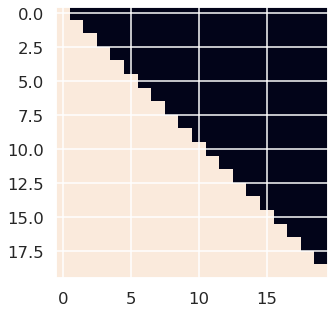

In [17]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(subsequent_mask(20)[0])

## Attention

In [18]:
def attention(query, key, value, mask=None, dropout=None):
  """
  Compute 'Scaled Dot Product Attention'
  """
  d_k = query.size(-1)
  scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
  if mask is not None:
    scores = scores.maksed_fill(mask == 0, -1e9)
  p_attn = F.softmax(scores, dim=-1)
  if dropout is not None:
    p_attn = dropout(p_attn)
    
  return torch.matmul(p_attn, value), p_attn